# MNIST classification with unsupervised help

In this task we will tinker with MNIST dataset and try to make sense of it with unsupervised techniques.

We will cover k-means, DBSCAN, PCA, t-SNE – all the algorithms we've covered in the videos.

This assignment is graded by your `submission.json`.

The cell below creates a valid `submission.json` file, fill your answers in there. 

You can press "Submit Assignment" at any time to submit partial progress.

In [37]:
%%file submission.json
{
    "q1": 0.753,
    "q2": 0.544,
    "q3": 0.300,
    "q4": 0.400
}

Overwriting submission.json


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from sklearn.cluster import KMeans, DBSCAN
from sklearn import datasets
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# K-means

Let's take a look at the example from the lecture video first to try out k-means.

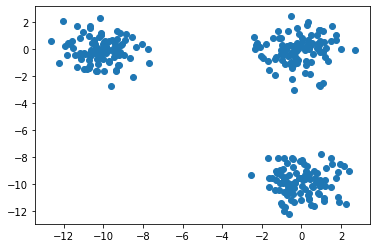

In [3]:
# generating simple dataset
np.random.seed(0)
X1 = np.random.normal(loc=[0, -10], size=(100, 2))
X2 = np.random.normal(loc=[-10, 0], size=(100, 2))
X3 = np.random.normal(loc=[0, 0], size=(100, 2))
X = np.vstack((X1, X2, X3))
plt.scatter(X[:,0], X[:,1])

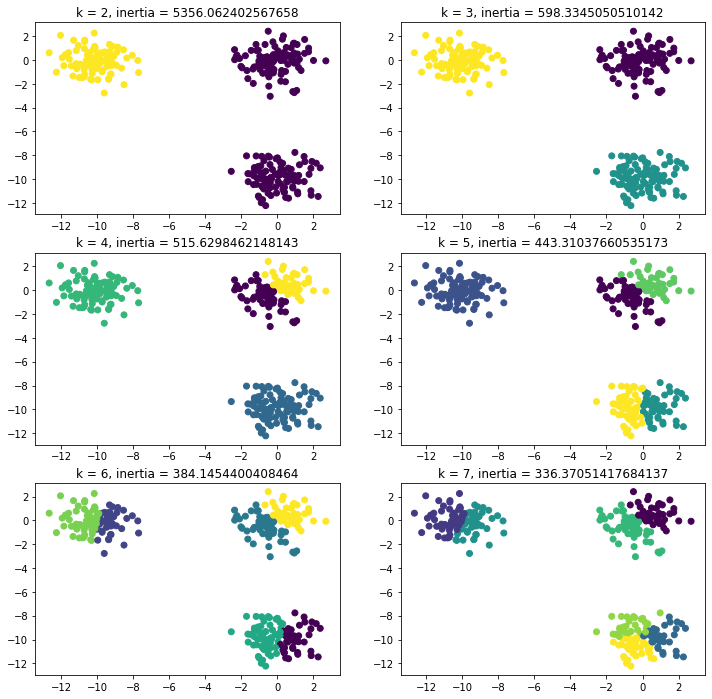

In [4]:
# trying out different k
inertia_values = []
k_values = []

plt.figure(figsize=(12, 12))
for k in range(2, 8):
    k_means = KMeans(n_clusters=k)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(3, 2, k - 1)
    plt.scatter(X[:,0], X[:,1], c=clusters)
    plt.title('k = {}, inertia = {}'.format(k, k_means.inertia_))
    inertia_values.append(k_means.inertia_)
    k_values.append(k)
plt.show()

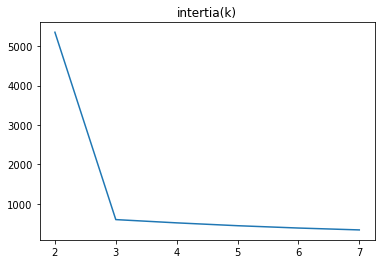

In [5]:
# choosing k with "elbow rule"
plt.plot(k_values, inertia_values)
plt.title('intertia(k)')
plt.show()

# DBSCAN

Let's explore DBSCAN properties on the same model dataset.

Two important parameters:
```
eps : float
    The maximum distance between two samples for one to be considered
    as in the neighborhood of the other.

min_samples : int
    The number of samples in a neighborhood for a point
    to be considered as a core point.
```

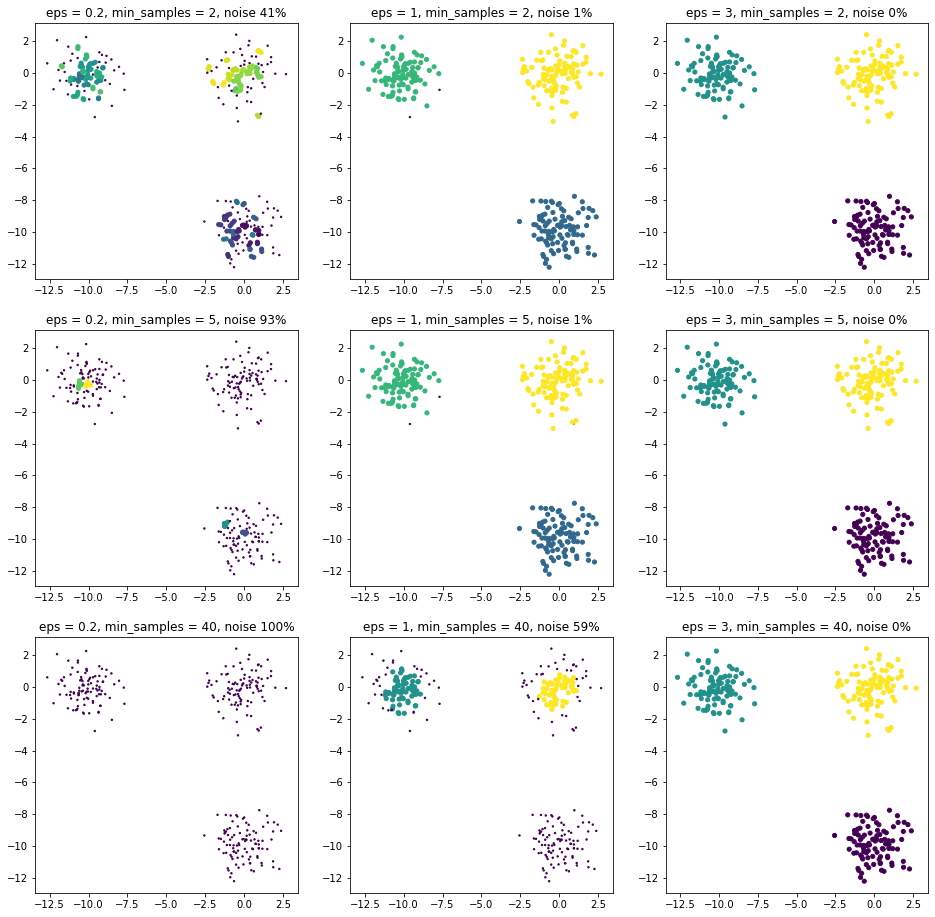

In [6]:
# as you can see you must guess optimal density parameters to find ideal clustering
# noise points are denoted by small circles
plt.figure(figsize=(16, 16))
i = 1
for min_samples in [2, 5, 40]:
    for eps in [0.2, 1, 3]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X)
        plt.subplot(3, 3, i)
        plt.scatter(X[:,0], X[:,1], c=clusters, s=15 * (clusters != -1) + 2)
        plt.title('eps = {}, min_samples = {}, noise {:.0f}%'.format(
            eps, min_samples, 100. * np.sum(clusters == -1) / len(X)))
        i += 1
plt.show()

# K-means vs DBSCAN

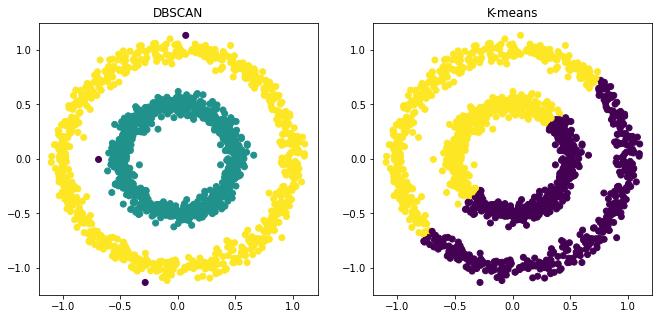

In [7]:
# DBSCAN can do miracles if you guess parameters right
X = datasets.make_circles(n_samples=1500, factor=.5, noise=.05)[0]

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
dbscan = DBSCAN(eps=0.1, min_samples=5)
clusters = dbscan.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.title('DBSCAN')

plt.subplot(1, 2, 2)
k_means = KMeans(n_clusters=2)
clusters = k_means.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.title('K-means')

plt.show()

# MNIST dataset

Handwritten digits from 0 to 9.

Shapes: (1797, 64) (1797,)
X[42]: [ 0.  0.  0.  0. 12.  5.  0.  0.  0.  0.  0.  2. 16. 12.  0.  0.  0.  0.
  1. 12. 16. 11.  0.  0.  0.  2. 12. 16. 16. 10.  0.  0.  0.  6. 11.  5.
 15.  6.  0.  0.  0.  0.  0.  1. 16.  9.  0.  0.  0.  0.  0.  2. 16. 11.
  0.  0.  0.  0.  0.  3. 16.  8.  0.  0.]
y[42]: 1


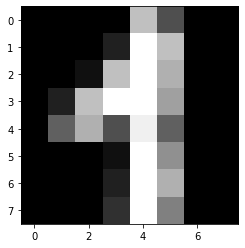

In [8]:
# images are stored as vectors of pixels of size 64
digits = datasets.load_digits()
X, y = digits['data'], digits['target']
print("Shapes:", X.shape, y.shape)
print("X[42]:", X[42])
print("y[42]:", y[42])

# show one image (reshaping vector into matrix)
plt.imshow(X[42].reshape(8, 8), cmap='gray')

Now it's your turn to write some code:
- Cluster MNIST with k-means (you know optimal k already).
- Assign a label to each cluster by the most popular `y` (classes from 0 to 9) in that cluster.

Now we can compute `accuracy_score` of our cluster labels comparing them with true label of each point.

This way we can get an idea of how good our clustering is without looking at it (because you can't really look at 64 dimensional points, right?).

__q1: What `accuracy_score` did you get?__

Hint: you can use `np.bincount(x)`:
```
Count number of occurrences of each value in array of non-negative ints.
Each bin gives the number of occurrences of its index value in `x`.

```

Hint: use `KMeans(..., random_state=0)` for reproducible results.

In [1]:
from sklearn.metrics import accuracy_score

# YOUR CODE HERE

You can try to do the same thing with DBSCAN, but it's hard to find parameters that yield exactly 10 good clusters.

Play around with it to find out (it will not be graded, it's for pure joy)!

To get rid of noise points you can use the following snippet (which assigns the closest cluster for every noise point):
```python
import sklearn
# fill -1 with nearest labels
if np.sum(clusters == -1) > 0 and np.sum(clusters != -1) > 0:
    nearest_labels = sklearn.metrics.pairwise_distances_argmin_min(
        X[clusters == -1], 
        X[clusters != -1], 
        axis=1, 
        metric='euclidean')[0]
    clusters[clusters == -1] = clusters[clusters != -1][nearest_labels]
```

<p style='transform: rotate(180deg)'><sub><sup>eps in range [21, 24] and min_samples=20 works best for me, yielding better accuracy than k-means</sup></sub></p>

In [ ]:
# YOUR CODE HERE

# PCA

Now let's try to visualize MNIST with 2 PCA components

In [ ]:
pca = PCA(n_components=2, random_state=0)
digits_2d_pc = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(digits_2d_pc[:, 0], digits_2d_pc[:, 1], c=y)
plt.colorbar()
plt.show()

Do you see any clusters? 

Let's train logistic regression (`sklearn.linear_model.LogisticRegression(random_state=0)`) on these 2 principal components and `y` labels to see how well our classes are separated on the plane.

__q2: What `accuracy_score` do you get with logistic regression?__

Hint: train the model on train set and report accuracy on the test set this time. Use provided split in the cell below.

In [ ]:
xtr, xte, ytr, yte = train_test_split(digits_2d_pc, y, test_size=0.2, random_state=0)

In [ ]:
# YOUR CODE HERE

# t-SNE 

Now let's visualize our digits with t-SNE, clusters will be much more visible!

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
digits_2d_tsne = tsne.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(digits_2d_tsne[:, 0], digits_2d_tsne[:, 1], c=y)
plt.colorbar()
plt.show()

__q3: What `accuracy_score` do you get training logistic regression on t-SNE components?__

Hint: train the model on train set and report accuracy on the test set. Use provided split in the cell below.

In [ ]:
xtr, xte, ytr, yte = train_test_split(digits_2d_tsne, y, test_size=0.2, random_state=0)

In [ ]:
# YOUR CODE HERE

__q4: What `accuracy_score` do you get training logistic regression on 3 t-SNE components this time?__

Hint: Remember to set random_state=0 in t-SNE, logistic regression, etc.

In [ ]:
# YOUR CODE HERE